In [1]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.append(str(project_root))

In [8]:
import yaml
from src.data_preprocessing.tokenizer import NSLTokenizer

with open("../config/config.yaml", 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

tokenizer = NSLTokenizer(config=config)

tokens_1 = tokenizer.tokenize("घर")
tokens_2 = tokenizer.tokenize("कख")

print(f"घर tokens: {tokens_1}")
print(f"कख tokens: {tokens_2}")

Vocabulary built! Size: 53 tokens.
घर tokens: [1, 21, 46, 2]
कख tokens: [1, 17, 19, 2]


In [9]:
import pandas as pd
df = pd.read_csv("../training_dataset/master_metadata.csv")

max_f = df['frames'].max()
mean_f = df['frames'].mean()
p95_f = df['frames'].quantile(0.95)

print(f"Longest Video: {max_f} frames")
print(f"Average Video: {mean_f:.2f} frames")
print(f"95% of videos are shorter than: {p95_f} frames")

Longest Video: 187 frames
Average Video: 57.35 frames
95% of videos are shorter than: 121.0 frames


In [ ]:
from src.inference.inference_engine import NSLGenerator
import numpy as np

gen = NSLGenerator("../experiments/best_model.pth", "../vocab.json")
word1 = gen.generate("अ")
word2 = gen.generate("क")

# Check if the arrays are mathematically identical
diff = np.abs(word1 - word2).sum()
print(f"Total numerical difference between 'अ' and 'क': {diff}")

if diff < 0.01:
    print("❌ The model is outputting identical motion. The Encoder is being ignored.")
else:
    print(f"✅ The model is trying to differentiate, but the movement is too small (Diff: {diff:.4f})")

📖 Vocabulary loaded from vocab.json
✅ Successfully loaded seed pose from: KA_31_61.npz
Total numerical difference between 'अ' and 'क': 2810.6962890625
✅ The model is trying to differentiate, but the movement is too small (Diff: 2810.6963)


📖 Vocabulary loaded from ../vocab.json


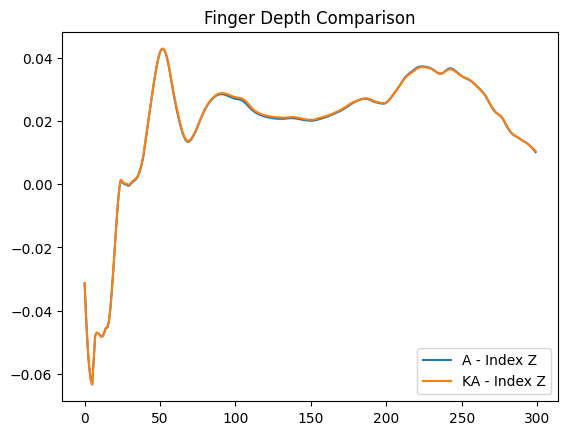

In [5]:
# Check Landmark 8 (Index Finger Tip) for two different letters
from src.inference.inference_engine import NSLGenerator

generator = NSLGenerator("../experiments/best_model.pth", "../vocab.json")

word1 = generator.generate("PHA")
word2 = generator.generate("RA")

# Plot the Z-coordinate of the index finger over time
import matplotlib.pyplot as plt
plt.plot(word1[:, 107], label="A - Index Z") # 99 (start of LH) + 8*1 = 107 roughly
plt.plot(word2[:, 107], label="KA - Index Z")
plt.legend()
plt.title("Finger Depth Comparison")
plt.show()

📖 Vocabulary loaded from ../vocab.json


c:\Users\bishe\anaconda3\envs\FYP\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 2325 (\N{DEVANAGARI LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\bishe\anaconda3\envs\FYP\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.print_figure(bytes_io, **kw)


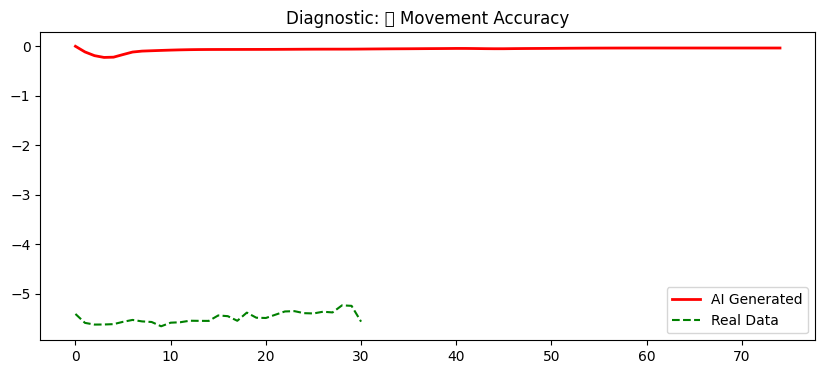

In [5]:
import matplotlib.pyplot as plt
from src.inference.inference_engine import NSLGenerator
import pandas as pd 
import numpy as np 


generator = NSLGenerator("../experiments/best_model.pth", "../vocab.json")

def diagnostic_plot(char, landmark_idx=8): # Landmark 8 is Index Finger Tip
    # 1. Generate the letter
    generated = generator.generate(char, frames_per_char=60)
    gen_finger_z = generated[:, 99 + landmark_idx*3 + 2] # Get Z coord of finger

    # 2. Load a real sample of that letter
    df = pd.read_csv("../training_dataset/master_metadata.csv")
    real_path = Path("../training_dataset") / df[df['char'] == char].iloc[0]['relative_path']
    real_data = np.load(real_path)['lh'][:, landmark_idx, 2] * 5.0 # Match training scale

    # 3. Plot
    plt.figure(figsize=(10, 4))
    plt.plot(gen_finger_z, label="AI Generated", color='red', linewidth=2)
    plt.plot(real_data, label="Real Data", color='green', linestyle='--')
    plt.title(f"Diagnostic: {char} Movement Accuracy")
    plt.legend()
    plt.show()

diagnostic_plot("क")